<a href="https://colab.research.google.com/github/intrandom5/School_notebook/blob/main/Best_mnist_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST 데이터셋은 0부터 9까지의 숫자 이미지를 보고 알맞는 숫자로 분류하는 작업이에요.

MNIST는 총 60,000개의 훈련 이미지와 10,000개의 테스트 이미지로 구성되어 있으며, 28x28 크기의 흑백 이미지로 구성되어 있어요.

아래 코드로 간편하게 다운 받을 수 있답니다.

In [ ]:
import torchvision.datasets as datasets


mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         download=True)

다운 받은 이미지는 아래와 같이 확인할 수 있습니다.

Text(0.5, 1.0, 'label : 7')

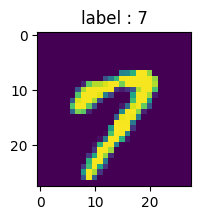

In [ ]:
import matplotlib.pyplot as plt

# idx의 값(0~59999)을 바꿔가면서 다른 이미지들도 확인해 보세요.
idx = 15

plt.figure(figsize=(2, 2))
plt.imshow(mnist_train.data[idx].unsqueeze(-1))
plt.title(f"label : {mnist_train.targets[idx]}")

이를 모델이 학습할 수 있도록 간단한 전처리를 해줄거에요.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class mnist_dataset(Dataset):
    def __init__(self, data):
        super(mnist_dataset, self).__init__()
        self.images = data.data[:5000]
        self.labels = data.targets[:5000]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "images": self.images[idx].view(-1)/255,
            "labels": self.labels[idx]
        }

train_dataset = mnist_dataset(mnist_train)
test_dataset = mnist_dataset(mnist_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

이제 데이터를 학습할 모델을 설계하겠습니다.

In [ ]:
from torch.optim import Adam


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.Linear(512, 128),
    nn.Linear(128, 64),
    nn.Linear(64, 10)
)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.00001)

준비된 데이터와 모델을 이용해 학습을 진행해 보겠습니다!

epoch : 0


100%|██████████| 157/157 [00:01<00:00, 112.79it/s]


epoch : 1


100%|██████████| 157/157 [00:01<00:00, 119.57it/s]


epoch : 2


100%|██████████| 157/157 [00:00<00:00, 274.46it/s]


정확도 : 61.4%


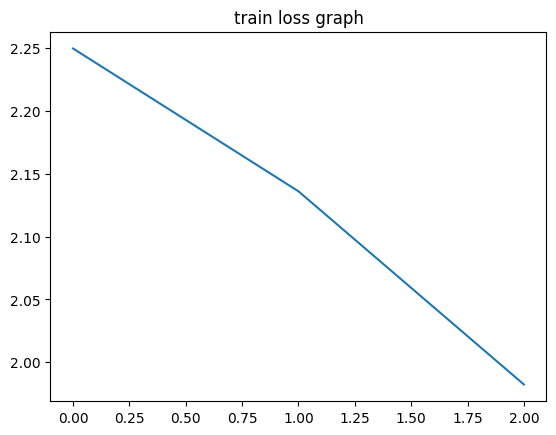

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train(model, optimizer, train_loader, epochs):
    train_losses = []

    for epoch in range(epochs):
        print("epoch :", epoch)
        model.train()
        train_loss = []
        for step, data in enumerate(tqdm(train_loader)):
            data = {k: v.to(device) for k, v in data.items()}

            images = data["images"].float()
            output = model(images)
            loss = criterion(output, data["labels"])
            train_loss.append(loss.detach().cpu().item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        step_loss = sum(train_loss)/len(train_loss)
        train_losses.append(step_loss)
        train_loss = []

    plt.plot(train_losses)
    plt.title("train loss graph")

def evaluate(model, test_loader):
    preds = []
    for step, data in enumerate(tqdm(test_loader)):
        data = {k: v.to(device) for k, v in data.items()}

        images = data["images"].float()
        with torch.no_grad():
            output = model(images).cpu()
        pred = torch.argmax(output, dim=-1)
        preds.append(pred)
    preds = torch.cat(preds)
    acc = accuracy_score(test_dataset.labels, preds)
    del preds

    return acc

train_losses = train(model, optimizer, train_loader, epochs=3)
test_score = evaluate(model, test_loader)
print(f"정확도 : {test_score*100}%")

몇 퍼센트의 정확도가 나왔나요?

이제 여러분이 직접 모델과 설정값들을 조절해서 더 좋은 모델을 만들어 볼게요.

모델은 아래와 같이 nn.Linear()의 숫자를 조절할 수 있습니다. 혹은 () 안의 숫자를 여러분이 바꾸고 싶은대로 바꿔도 돼요.

단, 맨 첫번째 nn.Linear(28\*28, x)에서 앞의 28*28은 고정값입니다. (이미지의 크기를 나타냅니다.)

그리고 맨 마지막 nn.Linear(x, 10)에서 뒤의 10도 고정값입니다. (0부터 9까지의 숫자를 나타냅니다.)

```
model = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.Linear(512, 10)
)

model = nn.Sequential(
    nn.Linear(28*28, 1024),
    nn.Linear(1024, 64),
    nn.Linear(64, 10)
)
```

그 외엔 학습률(lr)과 학습 반복 수(epochs), 배치 크기(batch_size)도 조절이 가능합니다!

학습률(lr)은 클수록 모델이 데이터에 크게 반응하고 작을수록 작게 반응해요.

epochs는 많을 수록 모델이 데이터를 많이 학습하게 됩니다.

batch_size는 모델이 몇 개의 데이터를 보고 학습할 지를 결정해요.

epoch : 0


100%|██████████| 79/79 [00:01<00:00, 61.18it/s]


epoch : 1


100%|██████████| 79/79 [00:01<00:00, 62.91it/s]


epoch : 2


100%|██████████| 157/157 [00:00<00:00, 477.08it/s]


정확도 :  77.98


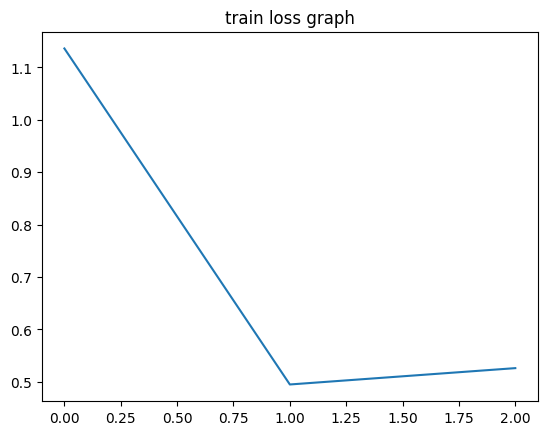

In [ ]:
del model

# 이제 여러분이 설정값을 조절해 더 좋은 모델을 만들어 보세요!

# 레이어의 수를 늘리거나 숫자를 조절할 수 있습니다!
model = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.Linear(512, 128),
    nn.Linear(128, 64),
    nn.Linear(64, 10)
)

# 학습률이에요. 클수록 모델이 크게 변하고, 작을수록 모델의 변화가 작아요.
lr = 0.00001

# epochs는 학습을 몇 번 반복할지를 결정해요.
epochs = 3

# batch_size는 모델이 데이터를 몇 개 보고 학습을 할 지를 결정해요. (< 5000)
batch_size=64

# 설정이 끝났으면 셀 실행!

# 아래 코드는 건들지 마세요.
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_losses = train(model, optimizer, train_loader, epochs)
test_score = evaluate(model, test_loader)
print("정확도 : ", test_score*100)